Attention Mechanism code taken from https://github.com/philipperemy/

In [15]:
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import Concatenate, concatenate
from keras.callbacks import TensorBoard

In [16]:
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul

In [17]:
# def model_attention_applied_before_lstm():
#     inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
#     attention_mul = attention_3d_block(inputs)
#     lstm_units = 64 
#     attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
#     output = Dense(1, activation='sigmoid')(attention_mul)
#     model = Model(input=[inputs], output=output)
#     return model

In [18]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    attention_muls = [] 
    for feature_name in features:
        input1 = Input(shape=(data_length,1), name=feature_name)
        inputs_list.append(input1)
        attention_muls.append(input1)
    
    layers = [] 
    for i, input_name in enumerate(attention_muls): 
        layers.append(LSTM(64, return_sequences=False)(attention_muls[i]) )
        
    output = concatenate(layers) 
    output = Dense(3, activation='softmax', name='IsSpike')(output)
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

data_length = 12


In [7]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd 
import numpy as np

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]

trends_df = pd.read_csv('C:/Users/Shoya/surf/data/Adj_Google_Trends_for_Mult_Keywords.csv', encoding='latin1') 
trends_cols = ["BitstampTrend", "CoinbaseTrend", "EthereumTrend", "BubbleTrend", "CryptocurrencyTrend", 
               "HashingTrend", "BlockchainTrend" ]

df[trends_cols] = trends_df[trends_cols]

display(df.head())

# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df = df.dropna()
cols = ['Volume_BTC','Bitcoin_Adj', 'Price_lagged',"BitstampTrend", "CoinbaseTrend", "EthereumTrend", "BubbleTrend", "CryptocurrencyTrend", 
               "HashingTrend", "BlockchainTrend"]

# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)

df_2 = pd.DataFrame(data_array, columns=cols)
df_2 = df_2.replace([np.inf, -np.inf], np.nan).dropna()
display(df_2.head())

# writer = pd.ExcelWriter("check.xlsx",  engine='xlsxwriter', options={'remove_timezone': True})
# df.to_excel(writer)
# writer.save()

data_mat = df_2.values 

# Min-Max Scale 

scalers = {}
datas = [] 

df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_mat[:,i]
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    #display(cols[i])
    #display(col_data)
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = data[0]
    
df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,Timestamp,Close,Volume_(BTC),Volume_(Currency),Date(UTC),Bitcoin (Adj.Overlap),Close Price % Change,Close Price % Change (Abs),Is Spike,BitstampTrend,CoinbaseTrend,EthereumTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend
0,1420840800,289.13,34.042422,9854.490388,2015-01-09 22:00:00,53.0,NaN,NaN,0,15.0,42.0,41.0,82.0,15.0,44.0,62.0
1,1420844400,292.15,36.628012,10733.474260,2015-01-09 23:00:00,52.0,0.010445,0.010445,1,16.0,48.0,39.0,86.0,25.0,44.0,53.0
2,1420848000,293.89,0.158015,46.439149,2015-01-10 00:00:00,52.0,0.005956,0.005956,1,17.0,53.0,45.0,90.0,27.0,50.0,53.0
3,1420851600,289.10,30.985828,8960.344674,2015-01-10 01:00:00,56.0,-0.016299,0.016299,-1,19.0,59.0,69.0,90.0,29.0,45.0,67.0
4,1420855200,288.59,7.694195,2224.105007,2015-01-10 02:00:00,53.0,-0.001764,0.001764,0,21.0,55.0,62.0,87.0,27.0,51.0,70.0


C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

,Volume_BTC,Bitcoin_Adj,Price_lagged,BitstampTrend,CoinbaseTrend,EthereumTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend
0,-5.445876,0.000000,0.005938,0.060625,0.099091,0.143101,0.045462,0.076961,0.127833,0.000000
1,5.278593,0.074108,-0.016433,0.111226,0.107246,0.427444,0.000000,0.071459,-0.105361,0.234401
2,-1.393064,-0.055060,-0.001766,0.100083,-0.070204,-0.106972,-0.033902,-0.071459,0.125163,0.043803
3,4.178019,0.306374,-0.006571,0.000000,0.018019,0.291706,0.055880,-0.076961,-0.125163,0.028171
4,-6.770292,-0.149532,0.005808,-0.100083,-0.074108,-0.547640,0.000000,-0.127833,0.144581,0.130053


,Volume_BTC,Bitcoin_Adj,Price_lagged,BitstampTrend,CoinbaseTrend,EthereumTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
1,0.776791,0.471970,0.484557,0.526899,0.565339,0.584618,0.535584,0.527141,0.328003,0.620269,1.0
2,0.463316,0.439996,0.538331,0.524515,0.506901,0.478824,0.512201,0.501026,0.390657,0.543009,1.0
3,0.725079,0.529463,0.520715,0.503101,0.535955,0.557747,0.574125,0.500021,0.322621,0.536672,-1.0
4,0.210661,0.416611,0.566098,0.481687,0.505616,0.391588,0.535584,0.490725,0.395935,0.577971,0.0
5,0.594148,0.445509,0.568881,0.503101,0.571612,0.487224,0.535584,0.652792,0.278450,0.431076,-1.0


,Volume_BTC,Bitcoin_Adj,Price_lagged,BitstampTrend,CoinbaseTrend,EthereumTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
30193,0.455905,0.449846,0.546519,0.498689,0.561916,0.514671,0.571703,0.525508,0.278450,0.589149,1.0
30194,0.308749,0.457405,0.549938,0.498596,0.544880,0.502343,0.549518,0.522206,0.324627,0.471125,-1.0
30195,0.632915,0.453625,0.563428,0.451915,0.504870,0.497657,0.514576,0.516713,0.356639,0.544110,1.0
30196,0.629822,0.434124,0.506657,0.401379,0.519397,0.497629,0.542658,0.508787,0.553393,0.568882,-1.0
30197,0.564642,0.445374,0.493535,0.493590,0.524578,0.490222,0.521362,0.541482,0.316794,0.557062,-1.0


In [8]:
input_features = cols[:]
# display(input_features)
all_features = input_features[:]
all_features.append("Is Spike")
# display(all_features)

original_data = {} 

for feature in all_features:
    original_data[feature] = df_scaled[feature].values
    
test_size_index = int(len(df_scaled["Volume_BTC"])/data_length)*data_length

train_size = int(len(df_scaled["Volume_BTC"]) * 0.80)
train_size = int(train_size/data_length) * data_length

train_data = {feature: [] for feature in all_features}
test_data = {feature: [] for feature in all_features} 

for i in range(train_size-data_length):
    temp_train = {input_features[i]:[] for i in range(len(input_features))}
        
    for j in range(data_length):
        for feature in input_features:
#             display(feature)
#             display(temp_train[feature])
#             display(original_data[feature])
            temp_train[feature].append(original_data[feature][i+j])
            
    for feature in input_features:
        train_data[feature].append(temp_train[feature])
        
    train_data["Is Spike"].append(original_data["Is Spike"][i+data_length])
    


for i in range(test_size_index-train_size-data_length):
    temp_test = {input_features[i]:[] for i in range(len(input_features))}

    for j in range(data_length):
        for feature in input_features:
            temp_test[feature].append(original_data[feature][train_size+i+j])
            
    for feature in input_features:
        test_data[feature].append(temp_test[feature])
    
    test_data["Is Spike"].append(original_data["Is Spike"][train_size+i+data_length])

# display(train_data["Close"][:100])
# # display(test_data)

In [9]:
from keras.utils.np_utils import to_categorical

for feature in all_features:
    train_data[feature] = np.array(train_data[feature])
    test_data[feature] = np.array(test_data[feature])

    
Y_train_is_spike_onehot = to_categorical(train_data["Is Spike"], num_classes=3)
Y_test_is_spike_onehot = to_categorical(test_data["Is Spike"],num_classes=3)

for feature in input_features:
    train_data[feature] = np.reshape(train_data[feature], (train_data[feature].shape[0], data_length,1))
    test_data[feature] = np.reshape(test_data[feature], (test_data[feature].shape[0], data_length,1))
    


In [19]:
key_features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged', 'BitstampTrend', 'CoinbaseTrend', 'CryptocurrencyTrend', 'HashingTrend', 'BlockchainTrend']

print("training with these input features: ", key_features)
print("data length is " + str(data_length))


rnn = build_model(key_features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        train_data[feature] for feature in key_features
    ],
    [
        Y_train_is_spike_onehot
    ]
    ,
#     validation_data=(
#         [
#             #X_val_timestamp,
#             X_val_volume,
#             #X_val_trends,
#             X_val_lagged_price
#         ],
#         [
#             Y_val_is_spike_onehot
#         ]),
    epochs=10,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

training with these input features:  ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged', 'BitstampTrend', 'CoinbaseTrend', 'CryptocurrencyTrend', 'HashingTrend', 'BlockchainTrend']
data length is 12
Epoch 1/10
24132/24132 [==============================] - 141s - loss: 1.0767 - categorical_accuracy: 0.4386   
Epoch 2/10
24132/24132 [==============================] - 138s - loss: 1.0758 - categorical_accuracy: 0.4390   
Epoch 3/10
24132/24132 [==============================] - 139s - loss: 1.0759 - categorical_accuracy: 0.4390   
Epoch 4/10
24132/24132 [==============================] - 140s - loss: 1.0753 - categorical_accuracy: 0.4390   
Epoch 5/10
24132/24132 [==============================] - 139s - loss: 1.0756 - categorical_accuracy: 0.4390   
Epoch 6/10
24132/24132 [==============================] - 139s - loss: 1.0753 - categorical_accuracy: 0.4390   
Epoch 7/10
24132/24132 [==============================] - 152s - loss: 1.0751 - categorical_accuracy: 0.4390   
Epoch 8/10
24132/24132 

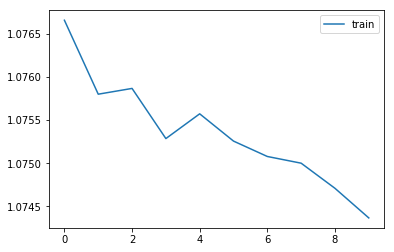

In [21]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [22]:
score = rnn.evaluate(
    [
        test_data[feature] for feature in key_features
    ],
    [
        Y_test_is_spike_onehot
    ])

print('\n')
print("Accuracy: %.2f%%" % (score[1]*100))

6036/6036 [==============================] - 13s    


Accuracy: 24.52%


In [23]:
import keras.backend as K

# from https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py

def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


In [24]:
get_activations(rnn, [train_data[feature] for feature in key_features], layer_name='attention_vec' )

----- activations -----


[]